## packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import talib as ta
import pandas as pd
import numpy as np

import os
import gc
import traceback

In [ ]:
import mysql.connector
import ast
with open('mysql_configure') as f:
    mysqlkeys = f.read()
    mysqlkeys = ast.literal_eval(mysqlkeys)
mydb = mysql.connector.connect(**mysqlkeys,
  database="mycrypto"
)

In [2]:
version_num = 1

In [3]:
DEBUG=True #load feature added data from crypto-lstm-data
############################################configure
##use GPU if no TPU
DEVICE = "TPU"
SEED = 42
EPOCHS = 10
N_ASSETS = 14 #14 assets
WINDOW_SIZE = 15 #15mins
BATCH_SIZE = 128
PCT_VALIDATION = 10 # last 10% of the data are used as validation set
print(f'N_ASSETS = {N_ASSETS}, WINDOW_SIZE ={WINDOW_SIZE}, BATCH_SIZE = {BATCH_SIZE},EPOCHS = {EPOCHS},PCT_VALIDATION={PCT_VALIDATION}')
 
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("failed to initialize TPU")
    else: DEVICE = "GPU"

if DEVICE != "TPU": strategy = tf.distribute.get_strategy()
if DEVICE == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

N_ASSETS = 14, WINDOW_SIZE =15, BATCH_SIZE = 128,EPOCHS = 20,PCT_VALIDATION=10
connecting to TPU...
Num GPUs Available:  1


## Data

In [4]:
#add name
data_path = './data'
# assets = pd.read_csv(data_path+'/asset_details.csv')
assets = pd.read_sql("select * from asset_details", mydb)
assets_names = dict(zip(assets.Asset_ID, assets.Asset_Name))
#the order of the cryptos collected at same timestamp.
mod_order = pd.read_csv(data_path+'/supplemental_train.csv').Asset_ID[:N_ASSETS]
assets_order = dict((t,i) for i,t in enumerate(mod_order))

if DEBUG:
    print('read data from crypto-lstm-data')
    train = pd.read_feather('./data/lstm/train_1.ftr')
else:
    df_train = pd.read_feather('./data/new_data3.ftr')
    train = df_train[df_train.timestamp > df_train.timestamp.quantile(0.9)]
    del df_train
    gc.collect()

train = train.set_index("timestamp")
print(f"Loaded data range {train.index.values.astype('datetime64[s]')[[0,-1]]}")

read data from crypto-lstm-data
Loaded data range ['2020-03-15T22:38:00' '2022-01-24T00:00:00']


In [5]:
train.dropna(axis=0,inplace=True)
train.shape

(13376136, 31)

## Add Features

In [6]:
fpara_dict={'std_lr_15': 30, 'std_Mkt_lrt_15': 10, 'std_Crypto_Index': 30, 
            'rsi': 30, 'adx': 50, 'macd_sig': 15, 'macd_s': 10, 'macd_l': 60, 'lrtn': 50, 
            'fastk2': 10, 'fastk1': 15, 'beta_s': '6h', 'beta_l': '2d', 'vol_sum': 15}

In [7]:
def log_return(series, periods=5):
    return np.log(series).diff(periods)

def beta_resid(df, window): 
    num, unit = int(window[:-1]),window[-1]
    if unit == 'h':
        width = 60*num
    elif unit == 'd':
        width = 60*24*num
    b = ((ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(width).mean())/ \
        (ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(width).mean())).rename(f"beta_{window}")
    b = b.replace([np.nan,np.inf,-np.inf], 0)
    resids = ta.SUB(df.lr_15, ta.MULT(b, df.Mkt_lrt_15)).rename(f"lr_15_resid_{window}")
    return pd.concat([b, resids],axis=1)

def lag_features(df,fastk1,fastk2,adx,macd_s,macd_l,macd_sig,rsi,vol_sum,std_Crypto_Index,std_lr_15,std_Mkt_lrt_15,**kwargs):    
    ####TECH indicators
    df['slowK'], df['slowD'] = ta.STOCH(df.High, df.Low, df.Close, 
                                        fastk_period=fastk1, slowk_period=int(3*fastk1/5), slowd_period=int(3*fastk1/5),
                                        slowk_matype=0, slowd_matype=0)
    df['fastK'], df['fastD'] = ta.STOCHF(df.High, df.Low, df.Close,
                                         fastk_period=fastk2, fastd_period=int(3*fastk2/5), 
                                         fastd_matype=0)
    df[f'rsi_{rsi}'] = ta.RSI(df['Close'], timeperiod=rsi)
    df[f'macd_{macd_s}_{macd_l}'],df[f'macd_signal_{macd_sig}'], df['macd_hist'] = \
                ta.MACD(df['Close'],fastperiod=macd_s, slowperiod=macd_l, signalperiod=macd_sig)
    df[f'adx_{adx}'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=adx)#Average Directional Movement Index
    df[f'vol_sum_{vol_sum}'] = ta.SMA(df['Volume'],vol_sum)*vol_sum
    ####std volatility
    df[f'std_lr_15_{std_lr_15}'] = ta.STDDEV(df.lr_15,timeperiod=std_lr_15, nbdev=1)
    df[f'std_Mkt_lrt_15_{std_Mkt_lrt_15}'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=std_Mkt_lrt_15, nbdev=1)
    df[f'std_Crypto_Index_{std_Crypto_Index}'] = ta.STDDEV(df.Crypto_Index,timeperiod=std_Crypto_Index, nbdev=1)

def get_features(df_feat, fpara_dict):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat[[f"beta_{fpara_dict['beta_s']}",f"lr_15_resid_{fpara_dict['beta_s']}"]] = beta_resid(df_feat, window = fpara_dict['beta_s'])
    df_feat[[f"beta_{fpara_dict['beta_l']}",f"lr_15_resid_{fpara_dict['beta_l']}"]] = beta_resid(df_feat, window = fpara_dict['beta_l'])
    df_feat[f"lrtn_index_{fpara_dict['lrtn']}"] = log_return(df_feat.Crypto_Index, fpara_dict['lrtn'])
    lag_features(df_feat, **fpara_dict)
    return df_feat

In [8]:
print('Adding features!')
if DEBUG:
    pass
else:    
    train = train.groupby('Asset_ID').apply(lambda x: get_features(x,fpara_dict))
    train.tail()

Adding features!


In [9]:
train.columns

Index(['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Target', 'Weight', 'lr_15', 'Mkt_lrt_15', 'Crypto_Index', 'beta_6h',
       'lr_15_resid_6h', 'beta_2d', 'lr_15_resid_2d', 'lrtn_index_50', 'slowK',
       'slowD', 'fastK', 'fastD', 'rsi_30', 'macd_10_60', 'macd_signal_15',
       'macd_hist', 'adx_50', 'vol_sum_15', 'std_lr_15_30',
       'std_Mkt_lrt_15_10', 'std_Crypto_Index_30'],
      dtype='object')

In [10]:
train.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,...,fastD,rsi_30,macd_10_60,macd_signal_15,macd_hist,adx_50,vol_sum_15,std_lr_15_30,std_Mkt_lrt_15_10,std_Crypto_Index_30
timestamp,,,,,,,,,,,,,,,,,,,,,
1584317820,0,57.0,10.199800,10.199800,10.160100,10.179700,1.288890e+03,10.173363,0.000108,0.105286,...,45.507408,39.440976,-0.140568,-0.130712,-9.856011e-03,17.396946,7.514201e+04,0.012469,0.007701,11.370817
1584317820,1,1626.0,5258.854286,5286.100000,5231.200000,5254.435714,2.276096e+02,5254.140230,-0.000951,0.165850,...,47.507549,42.201528,-67.636483,-63.511557,-4.124926e+00,20.176010,1.007982e+04,0.013680,0.007701,11.370817
1584317820,2,176.0,178.041667,182.800000,175.750000,177.953333,3.987450e+02,177.936055,0.001500,0.058657,...,42.714348,46.096436,-1.184663,-1.280949,9.628548e-02,28.170651,1.565346e+04,0.006099,0.007701,11.370817
1584317820,3,81.0,0.026598,0.026654,0.026570,0.026586,1.035210e+06,0.026616,0.000832,0.107797,...,53.986378,44.596384,-0.000311,-0.000321,1.021193e-05,22.154203,1.244153e+07,0.012590,0.007701,11.370817
1584317820,4,3.0,0.001679,0.001679,0.001679,0.001679,2.095206e+04,0.001679,-0.003214,0.086971,...,63.571977,51.680127,-0.000001,-0.000001,1.713221e-07,13.636661,1.876984e+07,0.009734,0.007701,11.370817


## Timestamp consistent and Reordering

In [11]:
#################### missing timestamp fillin and 14 assets all timestamp
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
#all aassets has same timestamps with missing fillin
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()

In [12]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
gc.collect()

Memory usage of dataframe is 3341.90 MB
Memory usage after optimization is: 1174.89 MB
Decreased by 64.8%


0

In [13]:
train.head(14)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Weight,...,fastD,rsi_30,macd_10_60,macd_signal_15,macd_hist,adx_50,vol_sum_15,std_lr_15_30,std_Mkt_lrt_15_10,std_Crypto_Index_30
timestamp,,,,,,,,,,,,,,,,,,,,,
1584317820,0,57.0,10.199800,10.199800,10.160100,10.179700,1.288890e+03,10.173363,0.000108,0.105286,...,45.500000,39.43750,-0.140625,-0.130737,-9.857178e-03,17.390625,7.514201e+04,0.012466,0.007702,11.367188
1584317820,5,158.0,2.025132,2.031127,2.019100,2.024675,3.868856e+04,2.023862,-0.002579,0.033905,...,56.000000,46.31250,-0.016464,-0.016464,-2.086163e-06,17.750000,1.418286e+06,0.010056,0.007702,11.367188
1584317820,7,88.0,4.986875,4.996600,4.969000,4.981175,1.551462e+03,4.983015,-0.003458,0.050873,...,65.375000,46.37500,-0.035797,-0.036560,7.667542e-04,10.351562,1.324782e+05,0.010635,0.007702,11.367188
1584317820,8,12.0,0.120650,0.121600,0.119700,0.120550,1.578208e+03,0.120470,0.012047,0.026871,...,57.031250,45.87500,-0.001474,-0.001466,-9.000301e-06,17.609375,2.490106e+05,0.014366,0.007702,11.367188
1584317820,4,3.0,0.001679,0.001679,0.001679,0.001679,2.095206e+04,0.001679,-0.003214,0.086975,...,63.562500,51.68750,-0.000001,-0.000001,1.788139e-07,13.632812,1.876984e+07,0.009735,0.007702,11.367188
1584317820,9,142.0,35.608856,35.786999,35.430000,35.580429,1.001084e+03,35.593536,0.003370,0.058655,...,56.406250,41.00000,-0.466064,-0.414307,-5.172729e-02,7.652344,7.783770e+04,0.011612,0.007702,11.367188
1584317820,3,81.0,0.026598,0.026654,0.026570,0.026586,1.035210e+06,0.026616,0.000832,0.107788,...,54.000000,44.59375,-0.000311,-0.000321,1.019239e-05,22.156250,1.244153e+07,0.012589,0.007702,11.367188
1584317820,10,3.0,176.000000,176.000000,174.000000,174.000000,2.008709e+00,175.800867,-0.005920,0.026871,...,16.671875,42.46875,-3.306641,-3.853516,5.468750e-01,3.515625,4.606149e+01,0.009193,0.005543,6.035156
1584317820,11,14.0,37.549999,37.639999,37.459999,37.529999,1.032570e+01,37.534838,0.008255,0.039368,...,64.687500,44.18750,-0.337646,-0.361328,2.360535e-02,10.023438,1.850088e+03,0.010704,0.007702,11.367188


In [14]:
train.set_index('Asset_ID',append=True, inplace=True)
train = train.reindex(list(zip(train.index.get_level_values('timestamp'),
                           list(mod_order)*int(train.shape[0]/14))) )

In [15]:
train.tail(14)

Count          Open          High           Low  \
timestamp  Asset_ID                                                     
1642982400 3          457.0      1.124904      1.126200      1.119907   
           2          139.0    302.506012    302.769989    301.799988   
           0          420.0    383.901337    384.002991    382.371002   
           1         2917.0  36262.039062  36302.000000  36176.449219   
           4          227.0      0.141784      0.141900      0.141300   
           5          468.0      2.272950      2.277700      2.260000   
           7          280.0     25.128433     25.191000     24.983999   
           6         2510.0   2540.678467   2543.100098   2533.959961   
           8           49.0      0.814567      0.815300      0.811200   
           9          214.0    112.292999    112.470001    111.839996   
           10          25.0   1833.564941   1834.699951   1831.050049   
           13         235.0      0.057520      0.057618      0.057389   
           12         492.0      0.200940      0.201066      0.199352   
           11          40.0    156.764008    156.929993    156.199997   

                            Close        Volume          VWAP  Target  \
timestamp  Asset_ID                                                     
1642982400 3             1.121151  2.499232e+05      1.123218     0.0   
           2           302.112000  2.096457e+02    302.422931     0.0   
           0           382.929993  1.490571e+03    383.253768     0.0   
           1         36221.988281  1.100532e+02  36247.575361     0.0   
           4             0.141391  1.009688e+06      0.141649     0.0   
           5             2.264800  2.021940e+05      2.269373     0.0   
           7            25.028067  6.709816e+03     25.093705     0.0   
           6          2536.151367  1.057766e+03   2538.323926     0.0   
           8             0.812400  6.019270e+03      0.813656     0.0   
           9           111.983330  1.243860e+03    112.127619     0.0   
           10         1833.018311  4.190290e+00   1833.173692     0.0   
           13            0.057478  8.988252e+05      0.057519     0.0   
           12            0.200092  2.983796e+06      0.200413     0.0   
           11          156.550003  7.439747e+01    156.638720     0.0   

                       Weight     lr_15  ...     fastD    rsi_30  macd_10_60  \
timestamp  Asset_ID                      ...                                   
1642982400 3         0.107788 -0.001616  ...  58.65625  55.84375    0.008171   
           2         0.058655  0.001066  ...  49.28125  62.28125    2.410156   
           0         0.105286 -0.001288  ...  44.71875  56.28125    2.667969   
           1         0.165894 -0.001337  ...  45.75000  54.34375  131.875000   
           4         0.086975 -0.000066  ...  39.75000  52.40625    0.000592   
           5         0.033905 -0.002785  ...  42.28125  53.12500    0.011772   
           7         0.050873 -0.004490  ...  44.37500  54.21875    0.159790   
           6         0.144165  0.000148  ...  52.68750  58.50000   19.187500   
           8         0.026871 -0.001189  ...  53.34375  59.03125    0.008934   
           9         0.058655 -0.001254  ...  48.15625  57.46875    0.794922   
           10        0.026871 -0.002008  ...  43.50000  54.53125    5.285156   
           13        0.043823 -0.000622  ...  40.75000  52.84375    0.000142   
           12        0.050873 -0.002306  ...  55.21875  56.62500    0.001636   
           11        0.039368 -0.000843  ...  62.37500  59.46875    1.371094   

                     macd_signal_15  macd_hist     adx_50    vol_sum_15  \
timestamp  Asset_ID                                                       
1642982400 3               0.009506  -0.001335  29.421875  5.311578e+06   
           2               2.787109  -0.377441  28.328125  3.515688e+03   
           0               3.316406  -0.649902  33.062500  1.203241e+04   
           1             173

In [16]:
mod_order

0      3
1      2
2      0
3      1
4      4
5      5
6      7
7      6
8      8
9      9
10    10
11    13
12    12
13    11
Name: Asset_ID, dtype: int64

In [17]:
train.iloc[-14*16,:]

Count                  1.082000e+03
Open                   1.118946e+00
High                   1.125600e+00
Low                    1.117000e+00
Close                  1.122964e+00
Volume                 5.545012e+05
VWAP                   1.122475e+00
Target                 0.000000e+00
Weight                 1.077881e-01
lr_15                  7.686615e-03
Mkt_lrt_15             4.161835e-03
Crypto_Index           6.504000e+03
beta_6h                1.389648e+00
lr_15_resid_6h         1.905441e-03
beta_2d                1.379883e+00
lr_15_resid_2d         1.946449e-03
lrtn_index_50          2.375793e-02
slowK                  3.346875e+01
slowD                  1.762500e+01
fastK                  8.062500e+01
fastD                  4.606250e+01
rsi_30                 6.053125e+01
macd_10_60             9.811401e-03
macd_signal_15         1.335144e-02
macd_hist             -3.543854e-03
adx_50                 2.996875e+01
vol_sum_15             6.008664e+06
std_lr_15_30           2.473

In [18]:
train = train.iloc[:-14*16,:]##fake target

## Data format for LSTM

In [19]:
#####################################make 3D-numpy arrays for train and targets
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)
features = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume',
        'lr_15', 'Mkt_lrt_15', 'Crypto_Index', 'beta_6h',
       'lr_15_resid_6h', 'beta_2d', 'lr_15_resid_2d', 'lrtn_index_50', 'slowK',
       'slowD', 'fastK', 'fastD', 'rsi_30', 'macd_10_60', 'macd_signal_15',
       'macd_hist', 'adx_50', 'vol_sum_15', 'std_lr_15_30',
       'std_Mkt_lrt_15_10', 'std_Crypto_Index_30']

train = train[features].values
train = train.reshape(-1, N_ASSETS, train.shape[-1])

assert targets.shape[0] == train.shape[0], "wrong data shape"
print(targets.shape[0] == train.shape[0])

PCT_VALIDATION = 10 # last 10% of the data are used as validation set
X_train, X_test = train[:-len(train)//PCT_VALIDATION], train[-len(train)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train)//PCT_VALIDATION], targets[-len(train)//PCT_VALIDATION:]

True


In [20]:
del train,targets
gc.collect()

0

In [21]:
######################################################windowing
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        #(train, targets) arrays tuple
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length#window size
        self.size = len(x_set)#unique timestamp size
    def __len__(self): 
        #number of batchs
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        #(train, targets) tuple
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])
        return np.array(batch_x), np.array(batch_y)

In [22]:
#######################################windowing
train_generator = sample_generator(X_train, y_train, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length = WINDOW_SIZE, batch_size = BATCH_SIZE)

## LSTM model design


- Lambda layer needed for assets separation;
- Masking layer. Generated records (filled gaps) has zeros as features values, so they are not used in the computations. (masking layer affects saved model to be correctly reloaded)
- Our sequence model architecture(lstm)
- Concatenation layer
- Dense layer


In [23]:
########################custom metrics
# def MaxCorrelation(y_true,y_pred): 
#     return -tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))

def Correlation(y_true,y_pred): 
    return tf.math.abs(tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None))
##########################custom loss func
# def masked_mse(y_true, y_pred):
#     mask = tf.math.not_equal(y_true, 0.)
#     y_true_masked = tf.boolean_mask(y_true, mask)
#     y_pred_masked = tf.boolean_mask(y_pred, mask)
#     return tf.keras.losses.mean_squared_error(y_true = y_true_masked, y_pred = y_pred_masked)

# def masked_mae(y_true, y_pred):
#     mask = tf.math.not_equal(y_true, 0.)
#     y_true_masked = tf.boolean_mask(y_true, mask)
#     y_pred_masked = tf.boolean_mask(y_pred, mask)
#     return tf.keras.losses.mean_absolute_error(y_true = y_true_masked, y_pred = y_pred_masked)

def masked_cosine(y_true, y_pred):
    '''
    2.x uses the negative similarity because it's used as a loss function
    masking layer cause problem to reload the saved model. Consider the nonmasked below.
    '''
    mask = tf.math.not_equal(y_true, 0.)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.keras.losses.cosine_similarity(y_true_masked, y_pred_masked)

def nonmasked_cosine(y_true, y_pred):
    '''
    2.x uses the negative similarity because it's used as a loss function
    '''
    return tf.keras.losses.cosine_similarity(y_true, y_pred)

############################define lstm layer
def get_squence_model(x):
    x = layers.LSTM(units=32, return_sequences=True)(x)
    return x

############################compile model
def get_model(n_assets = 14, trainshape=(15,14,12)):
    #Keras tensor
    x_input = keras.Input(shape=trainshape)
    ## parallel sequence model branches
    branch_outputs = []
    for i in range(n_assets):
        # Slicing the ith asset: x_input into x of the lambda function
        a = layers.Lambda(lambda x: x[:,:, i])(x_input) #lambda layer
        #a = layers.Masking(mask_value = 0., )(a) #masking layer bad for reloading saved model
        #a = get_squence_model(a)#lstm layer
        a = layers.LSTM(units=32, return_sequences=True)(a)
        a = layers.GlobalAvgPool1D()(a)#globalavgpool layer
        branch_outputs.append(a)
    
    x = layers.Concatenate()(branch_outputs)
    x = layers.Dense(units = 128)(x)#dense layer 0
    out = layers.Dense(units = n_assets)(x)#dense layer 1
    model = keras.Model(inputs=x_input, outputs=out)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
                    loss = nonmasked_cosine, metrics=[Correlation])
    return model


In [24]:
#######################################model compile enable GPU/TPU
model = get_model(n_assets=N_ASSETS,
                trainshape=(train_generator[0][0].shape[1], 
                            N_ASSETS, 
                            train_generator[0][0].shape[-1]))

2022-01-28 23:03:31.532789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-28 23:03:31.533441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 14, 27)] 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 15, 27)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 15, 27)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 15, 27)       0           input_1[0][0]                    
______________________________________________________________________________________________

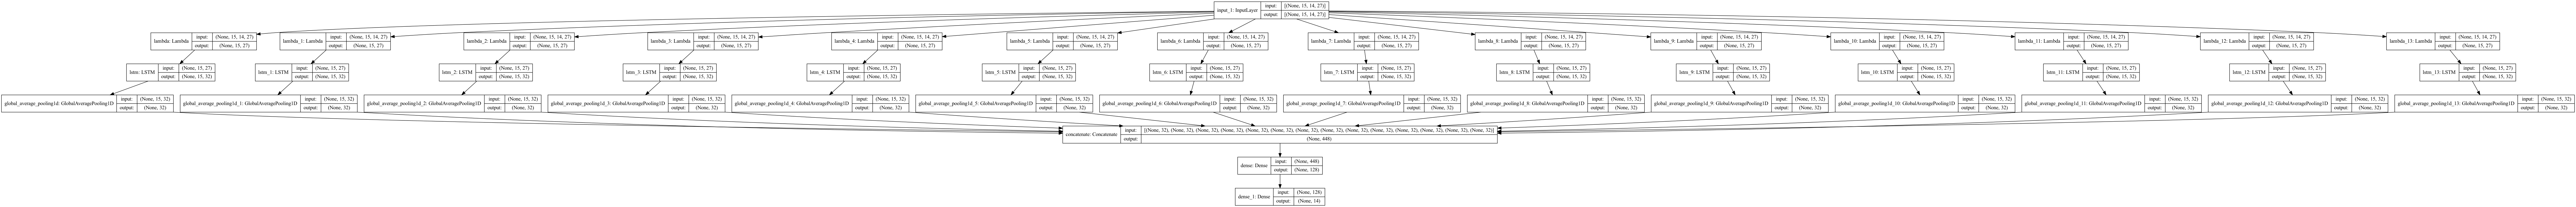

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True,to_file=f"./pic/lstm-kaggle{version_num}.png")

## Start model fitting

In [27]:
########################################model fit
tf.random.set_seed(0)
##early stop if 7 epoches no improvement on loss value of the val dataset
estop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 0, 
                                      mode = 'min',restore_best_weights = True)
##how the learning rate of your optimizer changes over time
scheduler = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, 
                                                        decay_steps=(0.5 * len(X_train) / BATCH_SIZE), 
                                                        decay_rate = 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

del X_train
del X_test
del y_train
del y_test
gc.collect()

print("start model fitting")
history = model.fit(train_generator, validation_data = (val_generator), 
                    epochs = EPOCHS, callbacks = [lr, estop])

print('finished model fitting')

start model fitting
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


2022-01-28 23:03:33.223730: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-28 23:03:37.213491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:03:38.483614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:03:38.494263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:03:38.537951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:03:38.567583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:03:38.580327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112

6875/6875 [==============================] - ETA: 0s - loss: -0.0186 - Correlation: 0.1404

2022-01-28 23:17:33.130788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:17:33.569292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:17:33.582408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:17:33.590621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:17:33.598746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:17:33.609851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-28 23:17:33.637949: I tensorflow/core/grappler/optimizers/cust

6875/6875 [==============================] - 868s 125ms/step - loss: -0.0186 - Correlation: 0.1404 - val_loss: -0.0032 - val_Correlation: 0.0732
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009979925, shape=(), dtype=float32).
6875/6875 [==============================] - 4705s 684ms/step - loss: -0.0221 - Correlation: 0.1479 - val_loss: -0.0036 - val_Correlation: 0.0650
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009959888, shape=(), dtype=float32).
6875/6875 [==============================] - 733s 107ms/step - loss: -0.0209 - Correlation: 0.1426 - val_loss: -0.0045 - val_Correlation: 0.0644
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009939893, shape=(), dtype=float32).
6875/6875 [==============================] - 730s 106ms/step - loss: -0.0228 - Correlation: 0.1519 - val_loss: -0.0051 - val_Correlation: 0.0620
Epoch 5/20

Epoch 00005: LearningRateScheduler settin

In [29]:
model.save(f"./trainedNN/kaggleLSTM_{version_num}")

INFO:tensorflow:Assets written to: ./trainedNN/kaggleLSTM_1/assets


INFO:tensorflow:Assets written to: ./trainedNN/kaggleLSTM_1/assets


## model performance